In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import requests
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS
from scipy.stats import norm

from utils import plot_samples

sns.set_palette("Set2")

In [2]:
data = requests.get("https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter3_MCMC/data/mixture_data.csv")

In [3]:
data = np.loadtxt(io.StringIO(data.text), delimiter=",")

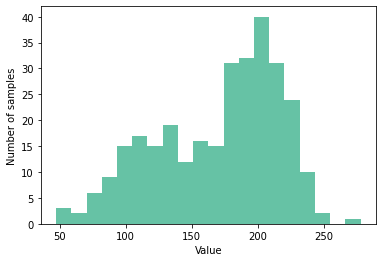

In [4]:
fig, ax = plt.subplots()

ax.hist(data, bins=20)

ax.set_xlabel("Value")
ax.set_ylabel("Number of samples")

plt.show()

In [5]:
def mixture_model(data):
    # We use an empirical approach to help convergence
    locs = torch.tensor([120.0, 190.0])
    scales = torch.tensor([10.0, 10.0])
    
    mus = pyro.sample("mus", dist.Normal(loc=locs, scale=scales).to_event(1))
    sigmas = pyro.sample("sigmas", dist.LogNormal(0.0, 5.0).expand([2]).to_event(1))

    ps = pyro.sample("ps", dist.Dirichlet(0.5 * torch.ones(2))).double()

    with pyro.plate("plate", data.shape[0]):
        cat = pyro.sample("cat", dist.Categorical(ps))
        pyro.sample("obs", dist.Normal(mus[cat], sigmas[cat]), obs=data)

In [6]:
nuts_kernel = NUTS(mixture_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=400)
mcmc.run(torch.tensor(data))

Sample: 100%|██████████| 2400/2400 [01:58, 20.21it/s, step size=3.15e-01, acc. prob=0.937]


In [7]:
mcmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

means = mcmc_samples["mus"].mean(axis=0)
sds = mcmc_samples["sigmas"].mean(axis=0)
ps = mcmc_samples["ps"].mean(axis=0)

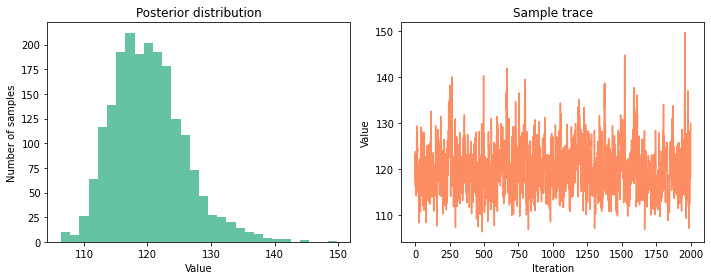

In [8]:
plot_samples(mcmc_samples["mus"][:, 0])

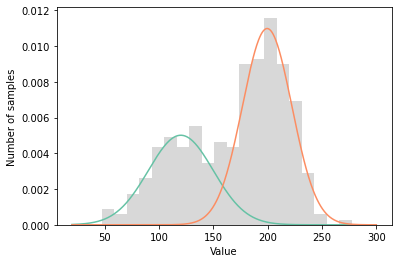

In [9]:
# We can plot the results using the posterior means
fig, ax = plt.subplots()

ax.hist(data, bins=20, alpha=0.5, density=True, color=sns.color_palette()[-1])

xx = np.linspace(20, 300, 500)
yy = norm.pdf(np.tile(xx, [2, 1]).T, loc=means, scale=sds)

ax.plot(xx, ps[0] * yy[:, 0], color=sns.color_palette()[0])
ax.plot(xx, ps[1] * yy[:, 1], color=sns.color_palette()[1])

ax.set_xlabel("Value")
ax.set_ylabel("Number of samples")

plt.show()